In [253]:
 
import urllib.request
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import re
labMTdata = pd.read_csv('labMT.csv')

stories = {
    "pride_and_predjudice": {
        "url": "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
        "start_word_pos": 6196,
        "end_word_pos": 154559
        }
}

def preprocess_text(text):
    ## for Frankenstein
    text = re.sub(r'D--n', 'Damn', text)
    ## separate out some basic punctuation
    text = re.sub(r'([!?,.])', r' \1 ', text)
    text = re.sub(r':', ' : ', text)
    text = re.sub(r';', r' ; ', text)
    ## remove underscores used for emphasis
    text = re.sub(r'_', '', text)
    ## isolate parentheses
    text = re.sub(r'\(', ' ( ', text)
    text = re.sub(r'\)', ' ) ', text)

    ## dash madness
    text = re.sub(r'----', ' --- ', text)  ## long dash
    text = re.sub(r'--', ' --- ', text)  ## em dash
    text = re.sub(r';—', ' --- ', text)  ## em dash
    text = re.sub(r'—', ' --- ', text)  ## em dash
    ## handle specific salutations
    text = re.sub(r'Mr \.', 'Mr.', text)
    text = re.sub(r'Mrs \.', 'Mrs.', text)
    text = re.sub(r'Dr \.', 'Dr.', text)
    ## clean up white space duplication
    text = re.sub(r'\s+', ' ', text)
    ## separate quotes
    ## opening quotes should have a space before them (except for em dashes, treat
    text = re.sub(r'\s"', ' " ', text)
    ## closing quotes should be what's left:
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r"'", " ' ", text)
    text = re.sub(r"'", "'", text)
    text = re.sub(r"(\s)'([a-zA-Z])", r"\1' \2", text)
    text = re.sub(r"([a-zA-Z])'(\s)", r"\1 '\2", text)
    text = re.sub(r"'s", " 's", text)
    ## add new line at the end
    text = text + "\n"
    # ## now create time series text by replacing spaces with returns
    timeseriestext = re.sub(r' ', '\n', text)
    # ## last: remove any white space redundancies
    timeseriestext = re.sub(r'\s+', '\n', timeseriestext, flags=re.MULTILINE | re.DOTALL)
    return timeseriestext
def extract_content_between(content, opening_string, closing_string):
    """
    Extracts content between opening_string and closing_string.
    
    Parameters:
    - content (str): The full text content
    - opening_string (str): The string marking the start
    - closing_string (str): The string marking the end
    
    Returns:
    - str: Content from opening_string to closing_string (inclusive), or None if not found
    """
    start_idx = content.find(opening_string)
    end_idx = content.find(closing_string)
    
    if start_idx == -1 or end_idx == -1:
        return None  # Strings not found
    
    return content[start_idx:end_idx + len(closing_string)]

def get_story(story_key):
    return stories[story_key]

def get_word_frequency(words):
    """
    Generates word counts.
    
    Parameters:
    - words (list): List of words to analyze for frequency.
    
    Returns:
    - DataFrame: DataFrame with word counts.
    """
    bow = pd.Series(words).value_counts().reset_index()
    bow.columns = ['word', 'counts']        
    bow = bow.sort_values(by='counts', ascending=False).reset_index(drop=True)
    return bow

def plot_zipf_distribution(words, story):
    """
    Plots the Zipf distribution for the given transcript.
    """        
    # Rank the words by frequency
    words['rank'] = words['counts'].rank(ascending=False, method='average').astype(int)
    
    # Log-transform rank and frequency
    log_rank = np.log10(words['rank'])
    log_freq = np.log10(words['counts'])
    
    # Perform linear regression to calculate the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
    
    # Plot the Zipf distribution (log-log scale)
    plt.figure(figsize=(5, 5))
    plt.loglog(words['rank'], words['counts'], marker=".", linestyle='none', color="grey")
    
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Zipf Law - {story}')
    plt.legend()
    plt.savefig(f"plots/{story}_zipf_log_space.png")
    plt.show()

['It', 'is', 'a', 'truth', 'universally', 'acknowledged', ',', 'that', 'a', 'single']
['Derbyshire', ',', 'had', 'been', 'the', 'means', 'of', 'uniting', 'them', '.']


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_88927/1659212038.py:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


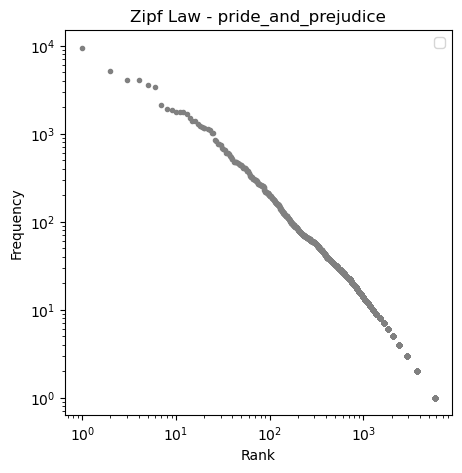

In [256]:
pride_and_prejudice = get_story("pride_and_predjudice")
url = pride_and_prejudice["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
pride_and_prejudice_cleaned = extract_content_between(content, 'It is a truth universally acknowledged', 'her into Derbyshire, had been the means of uniting them.')
processed_pride_and_prejudice = preprocess_text(pride_and_prejudice_cleaned)   
split_pride_and_prejudice = processed_pride_and_prejudice.splitlines()

print(split_pride_and_prejudice[:10])
# print first 10 words
# print last 10 words
print(split_pride_and_prejudice[-10:])
word_freq_df = get_word_frequency(split_pride_and_prejudice)
top_50_df = word_freq_df.head(50)
plot_zipf_distribution(word_freq_df, "pride_and_prejudice")


/opt/anaconda3/lib/python3.13/site-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


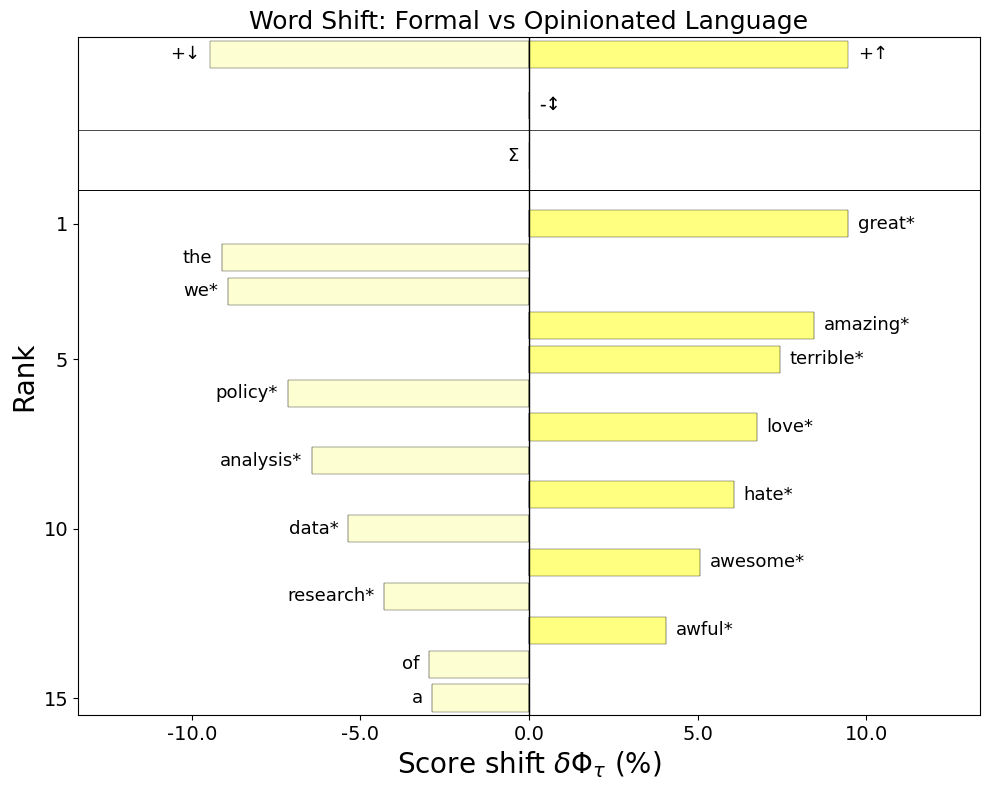

Word shift graph saved as 'word_shift_example.png'


<Figure size 640x480 with 0 Axes>

In [210]:
"""
Simple Word Shift Graph Example using Shifterator
"""

import shifterator as sh
import matplotlib.pyplot as plt

# Example: Comparing two different texts
# Text 1: More formal/neutral language
type2freq_1 = {
    'the': 120,
    'and': 80,
    'to': 70,
    'of': 65,
    'a': 60,
    'in': 55,
    'is': 45,
    'that': 40,
    'for': 35,
    'it': 30,
    'we': 25,
    'policy': 20,
    'analysis': 18,
    'data': 15,
    'research': 12
}

# Text 2: More opinionated/emotional language
type2freq_2 = {
    'the': 100,
    'and': 90,
    'to': 75,
    'of': 60,
    'a': 55,
    'in': 50,
    'is': 48,
    'that': 42,
    'for': 38,
    'it': 32,
    'great': 28,
    'amazing': 25,
    'terrible': 22,
    'love': 20,
    'hate': 18,
    'awesome': 15,
    'awful': 12
}

# Create a Shift object (using default uniform scores)
# handle_missing_scores='adopt' means if a word is missing in one dict, 
# use the score from the other dict
shift = sh.Shift(type2freq_1=type2freq_1, 
                 type2freq_2=type2freq_2,
                 handle_missing_scores='adopt')

# Generate the shift graph
fig, ax = plt.subplots(figsize=(10, 8))
shift.get_shift_graph(ax=ax,
                      top_n=15,
                      system_names=['Text 1 (Formal)', 'Text 2 (Opinionated)'],
                      title='Word Shift: Formal vs Opinionated Language',
                      cumulative_inset=False,  # Disable due to matplotlib compatibility
                      text_size_inset=False,
                      show_plot=True)

plt.tight_layout()
plt.savefig('word_shift_example.png', dpi=300, bbox_inches='tight')
print("Word shift graph saved as 'word_shift_example.png'")

In [232]:
# test preprocss function
test_string = "Hello, world! This is a test-string. Let's see: how well it works?"
preprocessed_test_string = preprocess_text(test_string)
print("Original String:")
print(test_string)
print("\nPreprocessed String:")
print(preprocessed_test_string)

Original String:
Hello, world! This is a test-string. Let's see: how well it works?

Preprocessed String:
Hello
,
world
!
This
is
a
test-string
.
Let
'
s
see
:
how
well
it
works
?



In [250]:
happiness_scores = []
for word in word_freq_df['word']:
    if word in labMTdata['Word'].values:
        score = labMTdata.loc[labMTdata['Word'] == word, 'Happiness Score'].values[0]
        if score <= 4 or score >= 6:
            happiness_scores.append(score)

In [252]:
# calculate average happiness score
if happiness_scores:
    average_happiness = sum(happiness_scores) / len(happiness_scores)
    print(f"Average Happiness Score (for scores <=4 or >=6): {average_happiness}")

Average Happiness Score (for scores <=4 or >=6): 5.739288590604029
